In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loss_simulator import simulate_empirical_risk, error_prob_model, compute_loss
import sys
sys.path.insert(0, '..')
from conformal_risk_control import StabilityEstimator

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 11

# Risk Distribution (Smooth Losses)

Compares risk distributions for smooth/continuous losses across:
- **CRC-C**: Conservative CRC
- **CRC**: Standard CRC
- **LTT**: Learn Then Test (adapted for smooth losses)

In [2]:
# Parameters
n_trials = 200
n_cal = 100
n_test = 1000
alpha = 0.1
instability_param = 0.3
base_strength = 10

print(f"Running {n_trials} trials (smooth losses)...")
print(f"Calibration size: {n_cal}")
print(f"Instability ε: {instability_param}\\n")

# Estimate beta once
P_cal_beta = np.random.uniform(0, 1, n_cal)
error_prob_cal = error_prob_model(P_cal_beta, alpha, base_strength, instability_param)
E_cal_beta = np.random.binomial(1, error_prob_cal)

estimator = StabilityEstimator(alpha=alpha, n_bootstrap=100)
beta_hat = estimator.estimate_beta_df(P_cal_beta, E_cal_beta)
alpha_conservative = max(0.01, alpha - beta_hat)
print(f"Estimated β̂ = {beta_hat:.4f}")
print(f"Conservative α' = {alpha_conservative:.4f}\\n")

risks_crc_c = []
risks_crc = []
risks_ltt = []

Running 200 trials (smooth losses)...
Calibration size: 100
Instability ε: 0.3\n
Estimated β̂ = 0.0488
Conservative α' = 0.0512\n


In [3]:
np.random.seed(42)

for trial in range(n_trials):
    if (trial + 1) % 50 == 0:
        print(f"  Completed {trial + 1}/{n_trials} trials...")
    
    # Generate data
    P_cal = np.random.uniform(0, 1, n_cal)
    error_prob_cal = error_prob_model(P_cal, alpha, base_strength, instability_param)
    y_cal = np.random.binomial(1, 1 - error_prob_cal)
    
    P_test = np.random.uniform(0, 1, n_test)
    error_prob_test = error_prob_model(P_test, alpha, base_strength, instability_param)
    y_test = np.random.binomial(1, 1 - error_prob_test)
    
    # For each method, find threshold minimizing smooth loss on calibration
    theta_grid = np.linspace(0, 1, 100)
    
    # CRC-C: minimize for conservative alpha
    risks_cal_c = []
    for theta in theta_grid:
        selected = P_cal > theta
        if selected.sum() > 0:
            losses = compute_loss(y_cal[selected], P_cal[selected], alpha_conservative)
            risks_cal_c.append(losses.mean())
        else:
            risks_cal_c.append(1.0)
    theta_crc_c = theta_grid[np.argmin(risks_cal_c)]
    
    # CRC: minimize for standard alpha
    risks_cal = []
    for theta in theta_grid:
        selected = P_cal > theta
        if selected.sum() > 0:
            losses = compute_loss(y_cal[selected], P_cal[selected], alpha)
            risks_cal.append(losses.mean())
        else:
            risks_cal.append(1.0)
    theta_crc = theta_grid[np.argmin(risks_cal)]
    
    # LTT: use empirical risk minimizer (standard)
    theta_ltt = theta_crc  # Same as CRC for smooth losses
    
    # Evaluate on test set
    selected_c = P_test > theta_crc_c
    selected = P_test > theta_crc
    selected_ltt = P_test > theta_ltt
    
    if selected_c.sum() > 0:
        risk_c = compute_loss(y_test[selected_c], P_test[selected_c], alpha_conservative).mean()
    else:
        risk_c = 1.0
    
    if selected.sum() > 0:
        risk = compute_loss(y_test[selected], P_test[selected], alpha).mean()
    else:
        risk = 1.0
    
    if selected_ltt.sum() > 0:
        risk_ltt = compute_loss(y_test[selected_ltt], P_test[selected_ltt], alpha).mean()
    else:
        risk_ltt = 1.0
    
    risks_crc_c.append(risk_c)
    risks_crc.append(risk)
    risks_ltt.append(risk_ltt)

risks_crc_c = np.array(risks_crc_c)
risks_crc = np.array(risks_crc)
risks_ltt = np.array(risks_ltt)

print(f"\\n✓ Completed all {n_trials} trials!")

  Completed 50/200 trials...
  Completed 100/200 trials...
  Completed 150/200 trials...
  Completed 200/200 trials...
\n✓ Completed all 200 trials!


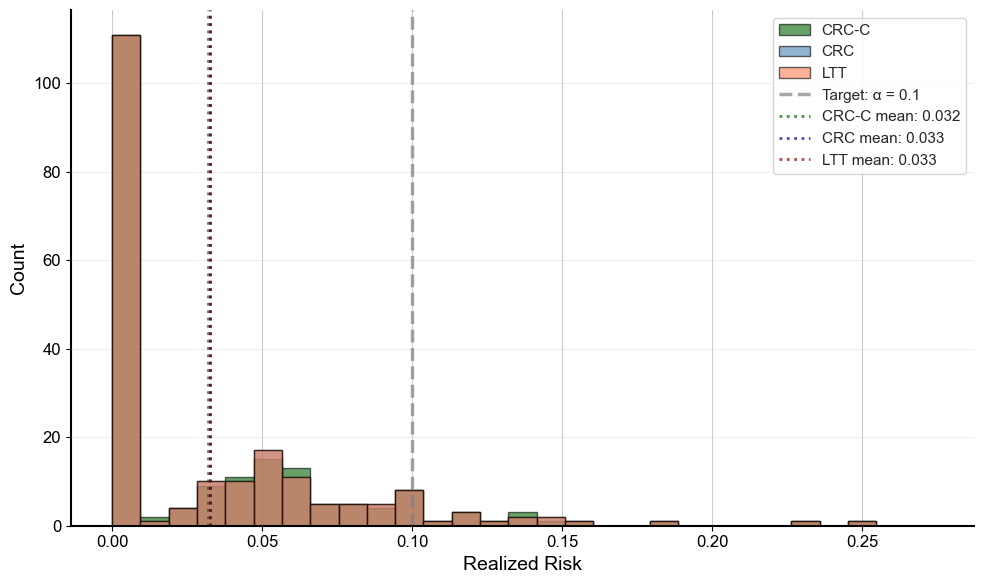

\n============================================================
SUMMARY STATISTICS (Smooth Losses)
Method          Mean Risk    Std        Violations  
------------------------------------------------------------
CRC-C           0.0320       0.0451     16/200
CRC             0.0326       0.0452     16/200
LTT             0.0326       0.0452     16/200


In [4]:
# Create histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bins = np.linspace(0, max(risks_crc_c.max(), risks_crc.max(), risks_ltt.max()) * 1.1, 30)

ax.hist(risks_crc_c, bins=bins, alpha=0.6, label='CRC-C', color='darkgreen', edgecolor='black')
ax.hist(risks_crc, bins=bins, alpha=0.6, label='CRC', color='steelblue', edgecolor='black')
ax.hist(risks_ltt, bins=bins, alpha=0.6, label='LTT', color='coral', edgecolor='black')

# Target and means
ax.axvline(x=alpha, color='gray', linestyle='--', linewidth=2.5, 
           label=f'Target: α = {alpha}', alpha=0.7)
ax.axvline(x=risks_crc_c.mean(), color='darkgreen', linestyle=':', linewidth=2,
           label=f'CRC-C mean: {risks_crc_c.mean():.3f}', alpha=0.7)
ax.axvline(x=risks_crc.mean(), color='darkblue', linestyle=':', linewidth=2,
           label=f'CRC mean: {risks_crc.mean():.3f}', alpha=0.7)
ax.axvline(x=risks_ltt.mean(), color='darkred', linestyle=':', linewidth=2,
           label=f'LTT mean: {risks_ltt.mean():.3f}', alpha=0.7)

# Formatting
ax.set_xlabel('Realized Risk', fontsize=14, color='black')
ax.set_ylabel('Count', fontsize=14, color='black')
ax.legend(fontsize=11, loc='best', frameon=True)
ax.grid(True, alpha=0.3, axis='y')
ax.tick_params(axis='x', colors='black', which='both', bottom=True, top=False)
ax.tick_params(axis='y', colors='black', which='both', left=True, right=False)
sns.despine(ax=ax, top=True, right=True)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_edgecolor('black')
    ax.spines[spine].set_linewidth(1.5)

plt.tight_layout()
plt.savefig('./outputs/risk_histogram_smooth.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Statistics
print("\\n" + "="*60)
print("SUMMARY STATISTICS (Smooth Losses)")
print("="*60)
print(f"{'Method':<15} {'Mean Risk':<12} {'Std':<10} {'Violations':<12}")
print("-"*60)
print(f"{'CRC-C':<15} {risks_crc_c.mean():<12.4f} {risks_crc_c.std():<10.4f} {(risks_crc_c > alpha).sum()}/{n_trials}")
print(f"{'CRC':<15} {risks_crc.mean():<12.4f} {risks_crc.std():<10.4f} {(risks_crc > alpha).sum()}/{n_trials}")
print(f"{'LTT':<15} {risks_ltt.mean():<12.4f} {risks_ltt.std():<10.4f} {(risks_ltt > alpha).sum()}/{n_trials}")
print("="*60)